In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Fri Oct 20 12:58:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |    359MiB / 15360MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import itertools
import os
import shutil
import random
from tensorflow.keras.applications.vgg16 import VGG16



In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load data
data_dir = "/content/drive/My Drive/CXR_train_images"

# Create a new directory for the sampled images
sampled_data_dir = "/content/drive/My Drive/CXR_sampled_dataset"
if not os.path.exists(sampled_data_dir):
    os.makedirs(sampled_data_dir)

# For each class directory, select 1000 random images and copy them to the new directory
for class_dir in os.listdir(data_dir):
    class_images = os.listdir(os.path.join(data_dir, class_dir))
    sampled_class_images = random.sample(class_images, 1000)  # select 1000 images

    new_class_dir = os.path.join(sampled_data_dir, class_dir)
    if not os.path.exists(new_class_dir):
        os.makedirs(new_class_dir)

    for image in sampled_class_images:
        src_path = os.path.join(data_dir, class_dir, image)
        dst_path = os.path.join(new_class_dir, image)
        shutil.copy2(src_path, dst_path)  # using copy2 can be slightly faster as it also copies metadata

# Now, use this sampled_data_dir for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Define train and validation generators
train_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="training",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)


Found 5461 images belonging to 2 classes.
Found 1365 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

# Initialize accumulators
total_images = 0
mean_accumulator = tf.zeros((224, 224, 3))
variance_accumulator = tf.zeros((224, 224, 3))
kurtosis_accumulator = tf.zeros((224, 224, 3))
skewness_accumulator = tf.zeros((224, 224, 3))

In [ ]:
from PIL import UnidentifiedImageError

def load_images_test(folder, filenames):
    images = []
    labels = []
    for filename in tqdm(filenames):
        try:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(folder, filename)
                img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
                x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
                x = np.expand_dims(x, axis=0)  # Numpy array with shape (1, 224, 224, 3)
                images.append(x)
                labels.append('out' in filename)  # Assign label based on the filename
        except UnidentifiedImageError:
            print(f"Cannot identify image file {filename}, skipping...")

    if not images:  # If no images are loaded
        raise ValueError(f"No images found in {folder}")

    return np.vstack(images), labels


In [ ]:

# Loop through the batches in the training generator
for batch_images, batch_labels in train_generator:
    # Convert batch to Tensor
    batch_images_tf = tf.convert_to_tensor(batch_images)

    # Calculate statistics for this batch
    batch_mean, batch_variance = tf.nn.moments(batch_images_tf, axes=[0])
    batch_std = tf.math.sqrt(batch_variance)
    batch_kurtosis = tf.reduce_mean((batch_images_tf - batch_mean)**4, axis=0) / (batch_std**4)
    batch_skewness = tf.reduce_mean((batch_images_tf - batch_mean)**3, axis=0) / (batch_std**3)

    # Update accumulators
    total_images += len(batch_images)
    mean_accumulator += batch_mean * len(batch_images)
    variance_accumulator += batch_variance * len(batch_images)
    kurtosis_accumulator += batch_kurtosis * len(batch_images)
    skewness_accumulator += batch_skewness * len(batch_images)

    # Check if we've processed all images
    if total_images >= train_generator.samples:
        break


In [ ]:
# Compute the overall statistics
mean_image = mean_accumulator / total_images
std_image = tf.math.sqrt(variance_accumulator / total_images)
kurtosis_image = kurtosis_accumulator / total_images
skewness_image = skewness_accumulator / total_images

print("Mean:", tf.reduce_mean(mean_image).numpy())
print("Standard Deviation:", tf.reduce_mean(std_image).numpy())
print("Kurtosis:", tf.reduce_mean(kurtosis_image).numpy())
print("Skewness:", tf.reduce_mean(skewness_image).numpy())


Mean: 0.5044843
Standard Deviation: 0.17981313
Kurtosis: 3.2636724
Skewness: -0.2456174


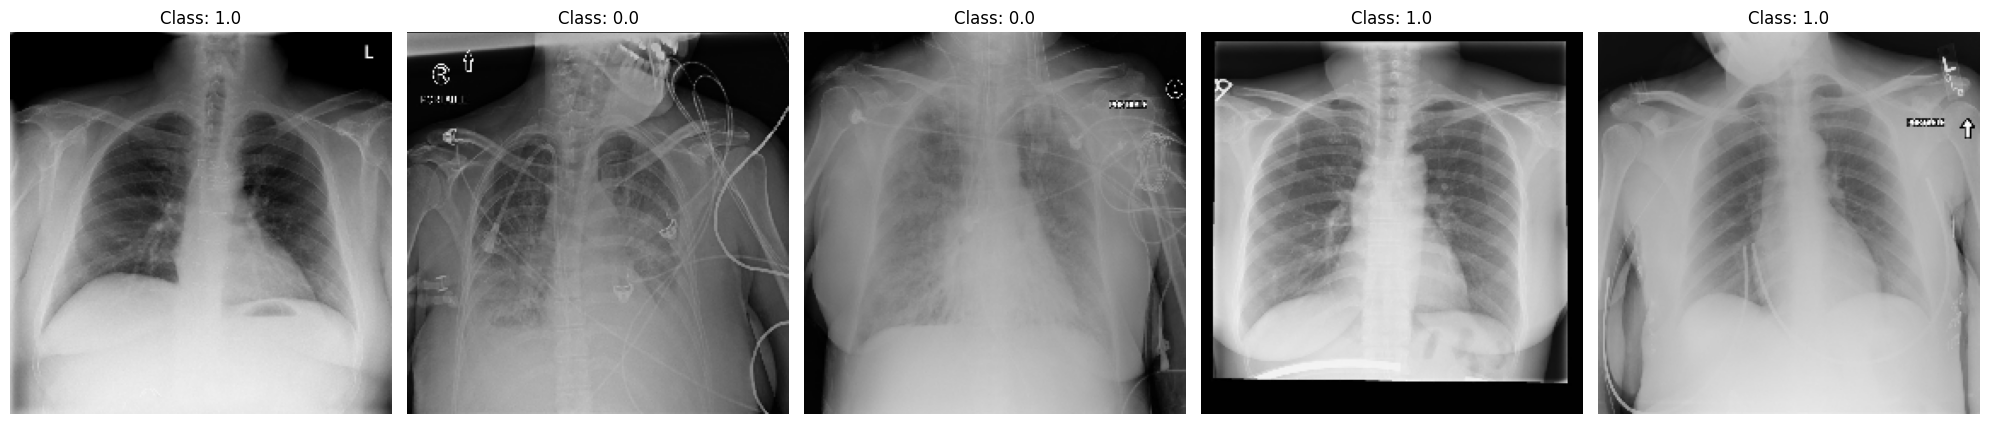

Found 5461 images belonging to 2 classes.
Found 1365 images belonging to 2 classes.


In [ ]:
import requests
import time
from PIL import Image


# Display some training images
def plot_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(f"Class: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Extract a batch of images and their labels from the train generator
images, labels = next(train_generator)

# Display the first 5 images from this batch
plot_images(images[:5], labels[:5])




def check_and_delete_corrupted_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # This will check if the image is valid
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)  # This will delete the corrupted image

# Use the function to check and delete corrupted images
check_and_delete_corrupted_images(sampled_data_dir)



# Recreate train and validation generators
train_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="training",
    class_mode="binary",
    target_size=(224, 224)
)

validation_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(224, 224)
)




Number of in-distribution images: 155
Number of out-distribution images: 39
Image names:
09102023.png
06212023.png
07262023.png
08222023.png
09032023.png
05142023.png
05082023.png
09272023.png
10062023.png
07162023.png
10162023.png
05182023.png
05092023_out.png
07102023.png
06012023_transfer.png
06082023_out.png
06272023.png
07092023.png
06032023_transfer.png
05272023.png
07112023.png
10132023.png
06152023_transfer.png
10082023.png
08172023.png
08072023.png
07242023.png
08282023.png
06302023.png
08292023.png
10252023_out.png
10182023.png
06162023_transfer.png
08252023.png
07222023.png
10282023.png
08052023.png
10272023_out.png
09122023.png
05292023_transfer.png
06062023_out.png
08272023.png
09012023.png
08152023.png
05032023.png
07122023.png
09232023.png
08012023.png
06242023.png
10262023_out.png
09212023.png
09282023.png
08312023.png
10142023.png
09092023_out.png
07232023.png
10292023_out.png
05302023.png
10102023.png
11022023_out.png
10302023_out.png
08192023.png
09262023.png
0916202

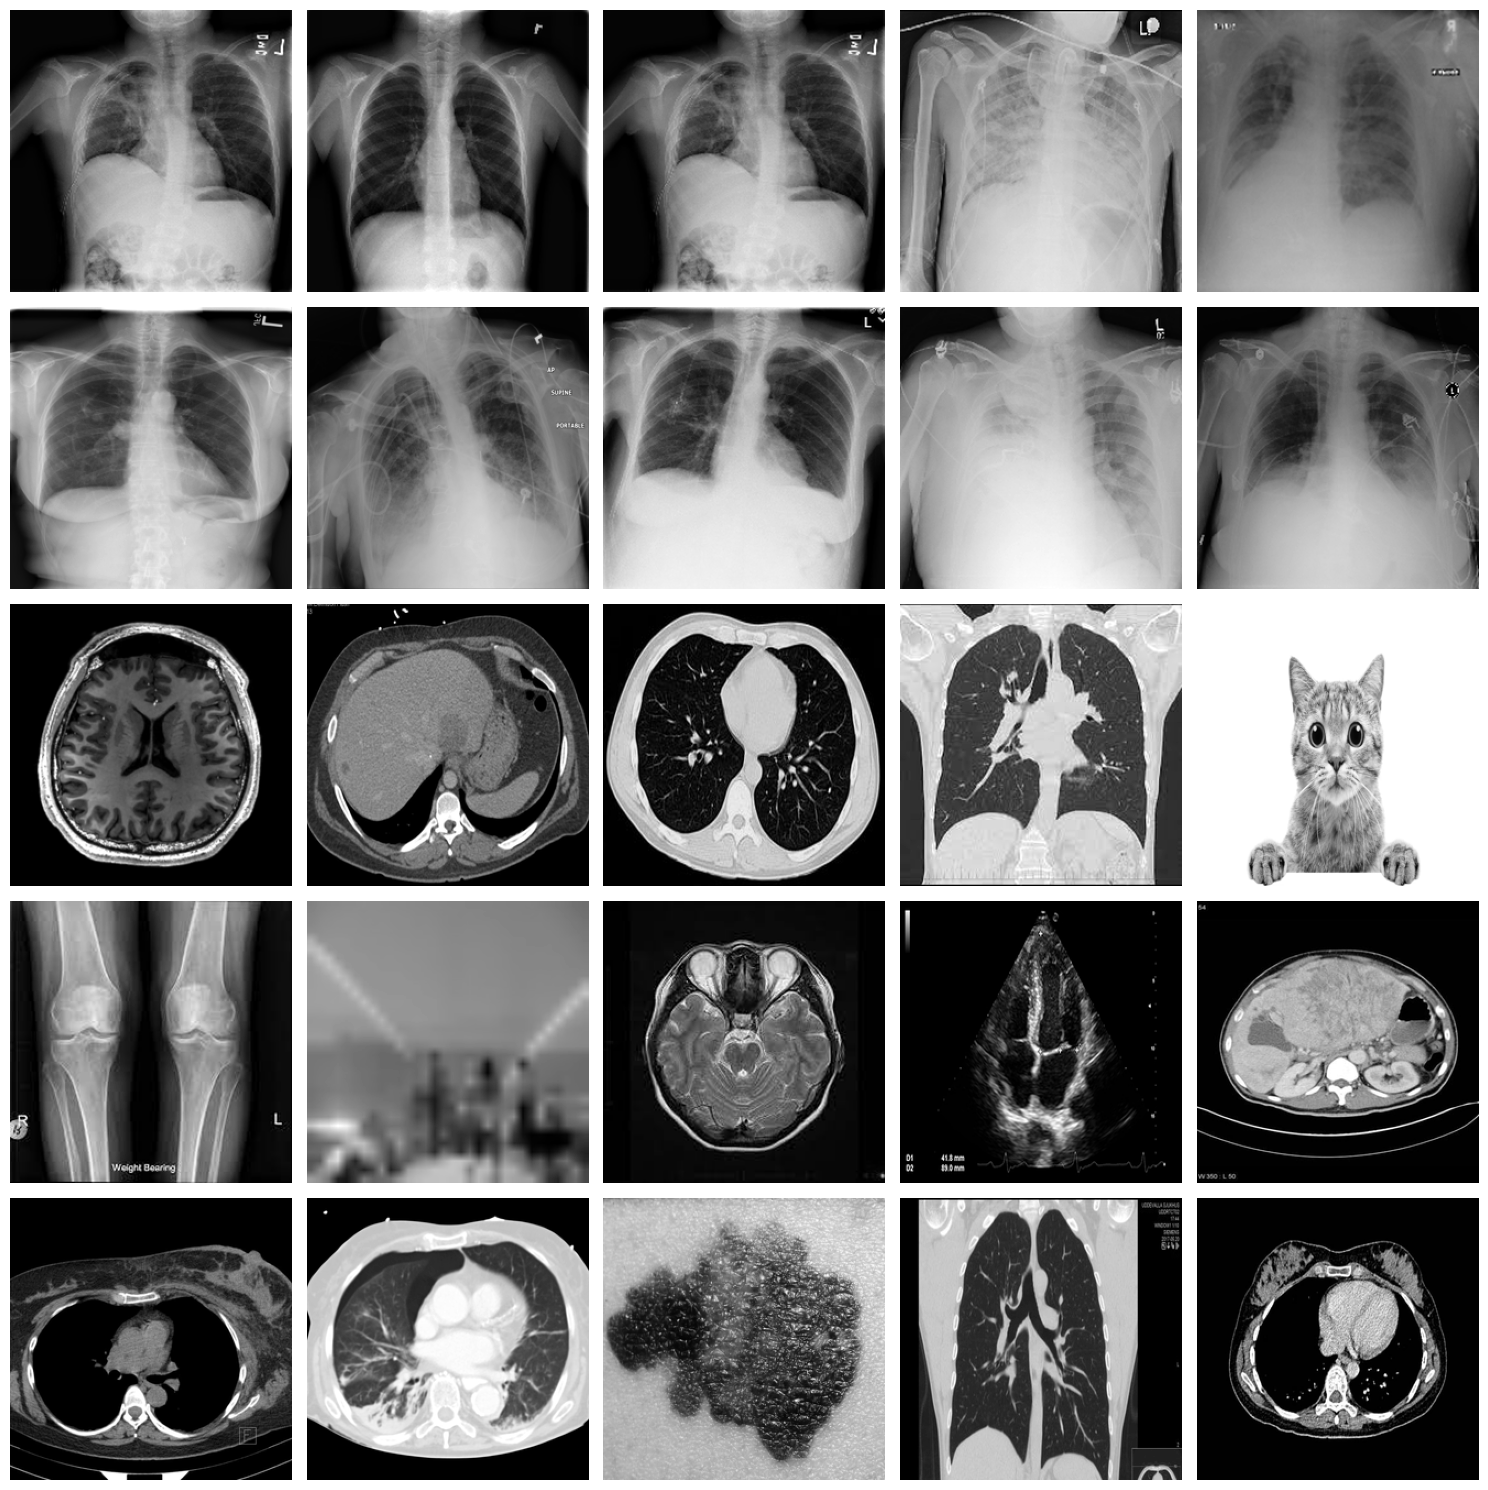

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Path to the test folder
test_folder = '/content/drive/MyDrive/ODD_test'  # Replace with the path to your test folder

# Segregate in-distribution and out-distribution images
in_dist_images = [image_name for image_name in os.listdir(test_folder) if "_out" not in image_name]
out_dist_images = [image_name for image_name in os.listdir(test_folder) if "_out" in image_name]

# Count the number of images in the test folder
print(f"Number of in-distribution images: {len(in_dist_images)}")
print(f"Number of out-distribution images: {len(out_dist_images)}")

# Display names
print("Image names:")
for image_name in os.listdir(test_folder):
    print(image_name)

# Select 10 in-distribution images and 15 out-distribution images for a 5x5 display
selected_images = in_dist_images[:10] + out_dist_images[:15]

plt.figure(figsize=(15, 15))
for i, image_name in enumerate(selected_images):
    img_path = os.path.join(test_folder, image_name)
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    # Removed the title line to not show image name

plt.tight_layout()
plt.show()  # Display the figure



Number of in-distribution images: 155
Number of out-distribution images: 39
Image names:
09102023.png
06212023.png
07262023.png
08222023.png
09032023.png
05142023.png
05082023.png
09272023.png
10062023.png
07162023.png
10162023.png
05182023.png
05092023_out.png
07102023.png
06012023_transfer.png
06082023_out.png
06272023.png
07092023.png
06032023_transfer.png
05272023.png
07112023.png
10132023.png
06152023_transfer.png
10082023.png
08172023.png
08072023.png
07242023.png
08282023.png
06302023.png
08292023.png
10252023_out.png
10182023.png
06162023_transfer.png
08252023.png
07222023.png
10282023.png
08052023.png
10272023_out.png
09122023.png
05292023_transfer.png
06062023_out.png
08272023.png
09012023.png
08152023.png
05032023.png
07122023.png
09232023.png
08012023.png
06242023.png
10262023_out.png
09212023.png
09282023.png
08312023.png
10142023.png
09092023_out.png
07232023.png
10292023_out.png
05302023.png
10102023.png
11022023_out.png
10302023_out.png
08192023.png
09262023.png
0916202

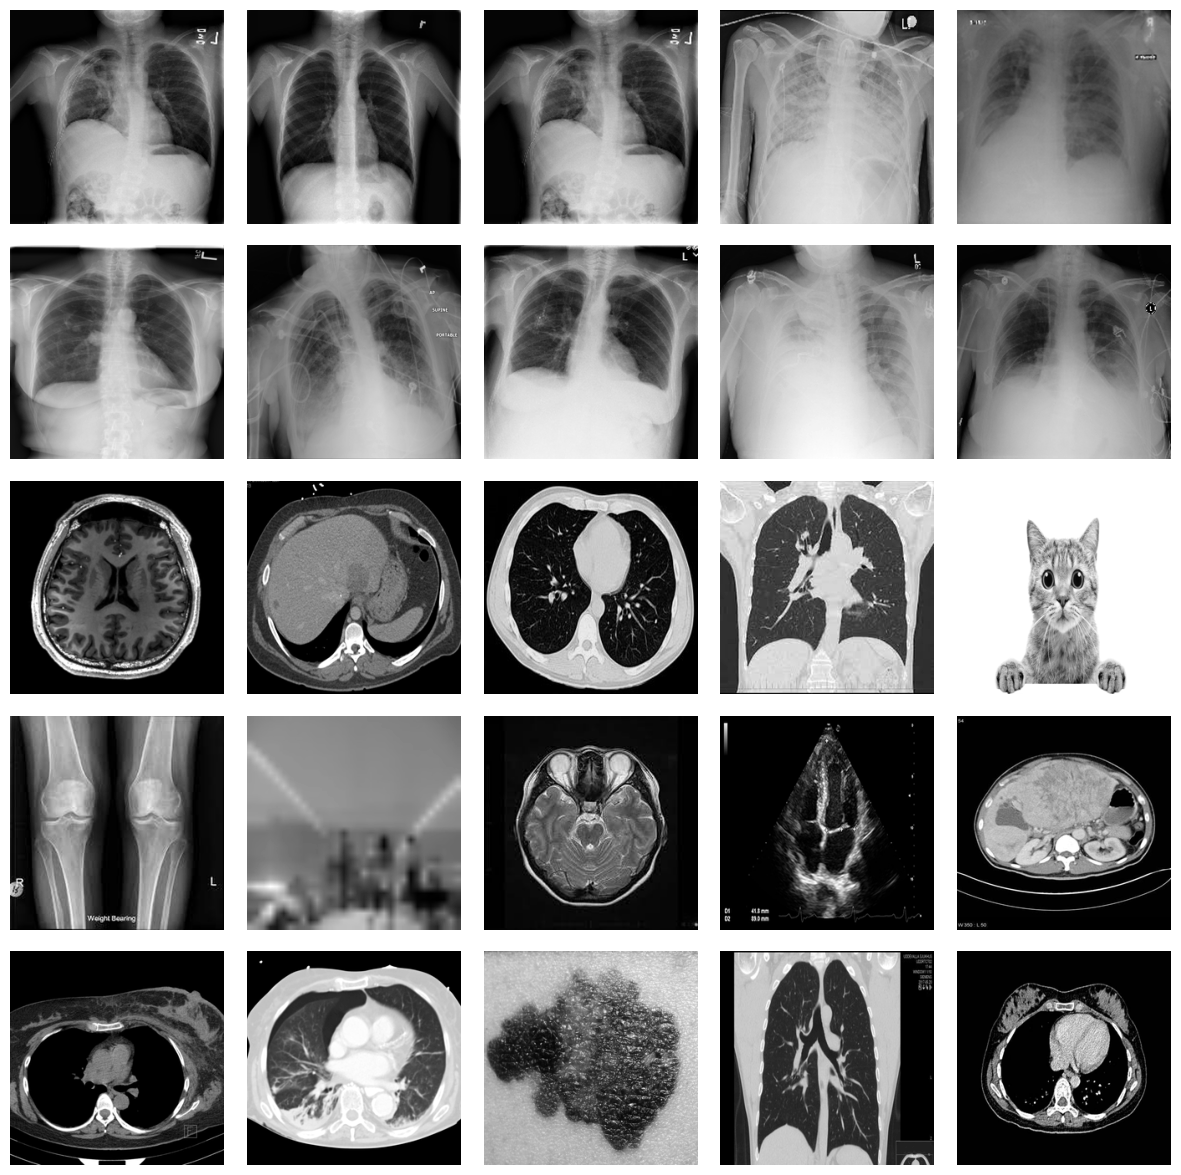

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the test folder
test_folder = '/content/drive/MyDrive/ODD_test'  # Replace with the path to your test folder

# Segregate in-distribution and out-distribution images
in_dist_images = [image_name for image_name in os.listdir(test_folder) if "_out" not in image_name]
out_dist_images = [image_name for image_name in os.listdir(test_folder) if "_out" in image_name]

# Count the number of images in the test folder
print(f"Number of in-distribution images: {len(in_dist_images)}")
print(f"Number of out-distribution images: {len(out_dist_images)}")

# Display names
print("Image names:")
for image_name in os.listdir(test_folder):
    print(image_name)

# Select 10 in-distribution images and 15 out-distribution images for display
selected_images = in_dist_images[:10] + out_dist_images[:15]

plt.figure(figsize=(15, 15))

for i, image_name in enumerate(selected_images):
    img_path = os.path.join(test_folder, image_name)
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Reduce space between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()  # Display the figure



In [ ]:
import tensorflow as tf
import pandas as pd

# Initialize a dictionary to store statistics for each image
image_statistics = {}

# Iterate over each image in the test folder
for image_name in os.listdir(test_folder):
    # Load the image using TensorFlow
    img_path = os.path.join(test_folder, image_name)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float for computations

    # Calculate statistics for the image
    mean_val = tf.reduce_mean(img).numpy()
    std_val = tf.math.reduce_std(img).numpy()
    kurtosis_val = tf.reduce_mean((img - mean_val)**4).numpy() / (std_val**4)
    skewness_val = tf.reduce_mean((img - mean_val)**3).numpy() / (std_val**3)

    # Store the statistics in the dictionary
    image_statistics[image_name] = {
        "Mean": mean_val,
        "Standard Deviation": std_val,
        "Kurtosis": kurtosis_val,
        "Skewness": skewness_val
    }

# Convert the dictionary to a DataFrame and save as a CSV file
df = pd.DataFrame.from_dict(image_statistics, orient="index")
csv_path = os.path.join('/content/drive/MyDrive/', 'image_statistics.csv')
df.to_csv(csv_path)

print(f"Statistics saved to {csv_path}")


Statistics saved to /content/drive/MyDrive/image_statistics.csv


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming you already have a dataframe 'df' loaded with your data
# Define the path to your CSV file if needed
# csv_path = "path_to_your_csv_file"
# df = pd.read_csv(csv_path, index_col=0)

def apply_spc_rules(data, mean, std):
    violations = {"Rule 1": [], "Rule 2": [], "Rule 3": [], "Rule 4": [], "Rule 5": [], "Rule 6": []}

    for i in range(len(data)):
        if abs(data[i] - mean) > 3 * std:
            violations["Rule 1"].append(i)
        #if i >= 8 and (all(d > mean for d in data[i-8:i+1]) or all(d < mean for d in data[i-8:i+1])):
        #    violations["Rule 2"].extend(list(range(i-8, i+1)))
        #if i >= 5 and all(data[j] < data[j+1] for j in range(i-5, i)) or all(data[j] > data[j+1] for j in range(i-5, i)):
        #    violations["Rule 3"].extend(list(range(i-5, i+1)))
        #if i >= 13 and all((data[j] < data[j+1] and data[j+1] > data[j+2]) or
        #                   (data[j] > data[j+1] and data[j+1] < data[j+2]) for j in range(i-13, i, 2)):
        #    violations["Rule 4"].extend(list(range(i-13, i+1)))
        #if i >= 2 and sum(1 for j in range(i-2, i+1) if abs(data[j] - mean) > 2 * std) >= 2:
        #    violations["Rule 5"].extend(list(range(i-2, i+1)))
        #if i >= 4 and sum(1 for j in range(i-4, i+1) if abs(data[j] - mean) > std) >= 4:
        #    violations["Rule 6"].extend(list(range(i-4, i+1)))

    return violations

def plot_spc_chart(distances, mean, UCL, LCL, title, rule, ood_labels=None):
    plt.figure(figsize=(10, 6))

    # Make the primary data plot grey
    plt.plot(distances, color='grey', marker='o', markersize=4, linestyle='-')

    # Change the mean line to black
    plt.axhline(y=mean, color='black', linestyle='-')

    # Change UCL and LCL to black dashed lines
    plt.axhline(y=UCL, color='black', linestyle='--')
    plt.axhline(y=LCL, color='black', linestyle='--')

    # Shade between UCL and LCL in grey
    plt.fill_between(range(len(distances)), LCL, UCL, color='grey', alpha=0.1)

    plt.xlabel('Image Sequence')
    plt.ylabel(statistic_name)

    violations = apply_spc_rules(distances, mean, (UCL - mean) / 3)

    # Change violated points to black "+" markers
    for idx in violations[rule]:
        plt.plot(idx, distances[idx], '*', color='black', markersize=6)

    if ood_labels is not None:
        for i in range(len(ood_labels)):
            if ood_labels[i] == 1:
                plt.plot(i, distances[i], marker='o', fillstyle='none', color='grey', markersize=15)

    # Uncomment the next line if you want the title back
    # plt.title(title + f" ({rule} Violations)")

    plt.xlim(0, len(distances) - 1)
    plt.show()

    return violations[rule]





In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

def plot_spc_chart(distances, mean, UCL, LCL, title, rule, ood_labels=None):
    plt.figure(figsize=(12, 6))

    # Make the primary data plot black
    plt.plot(distances, color='black', marker='o', markersize=4, linestyle='-')

    # Change the mean line to black
    plt.axhline(y=mean, color='black', linestyle='-')

    # Change UCL and LCL to black dashed lines
    plt.axhline(y=UCL, color='black', linestyle='--')
    plt.axhline(y=LCL, color='black', linestyle='--')

    # Shade between UCL and LCL in grey
    plt.fill_between(range(len(distances)), LCL, UCL, color='grey', alpha=0.1)

    plt.xlabel('Image Sequence')
    plt.ylabel(title)

    violations = apply_spc_rules(distances, mean, (UCL - mean) / 3)

    # Change violated points to black "+" markers
    for idx in violations[rule]:
        plt.plot(idx, distances[idx], '*', color='black', markersize=6)

    # Draw circles around OOD points
    if ood_labels is not None:
        for i in range(len(ood_labels)):
            if ood_labels[i] == 'out':  # changed from '1' to 'out' based on your description
                plt.plot(i, distances[i], marker='o', fillstyle='none', color='black', markersize=15)

    plt.xlim(0, len(distances) - 1)
    plt.show()

    return violations[rule]



In [ ]:
import matplotlib.pyplot as plt

def plot_spc_chart(distances, mean, UCL, LCL, title, rule, ood_labels=None):
    plt.figure(figsize=(16, 6))
    plt.plot(distances, color='black', marker='o', markersize=4, linestyle='-')
    plt.axhline(y=mean, color='black', linestyle='-')
    plt.axhline(y=UCL, color='black', linestyle='--')
    plt.axhline(y=LCL, color='black', linestyle='--')
    plt.fill_between(range(len(distances)), LCL, UCL, color='grey', alpha=0.1)

    plt.xlabel('Image Sequence', fontname="Arial", fontsize=12)
    plt.ylabel(title, fontname="Arial", fontsize=12)
    plt.xticks(fontname="Arial", fontsize=12)
    plt.yticks(fontname="Arial", fontsize=12)

    # Assuming you have a function apply_spc_rules() which was not provided in your code
    violations = apply_spc_rules(distances, mean, (UCL - mean) / 3)

    for idx in violations[rule]:
        plt.plot(idx, distances[idx], '*', color='grey', markersize=16, label='Auto OOD')

    if ood_labels is not None:
        for i, is_out in enumerate(ood_labels):
            if is_out:
                plt.plot(i, distances[i], marker='o', markersize=16, linestyle='None', color='black', mfc='none', label='Actual OOD')

    plt.xlim(0, len(distances) - 1)

    # Ensure no duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.show()


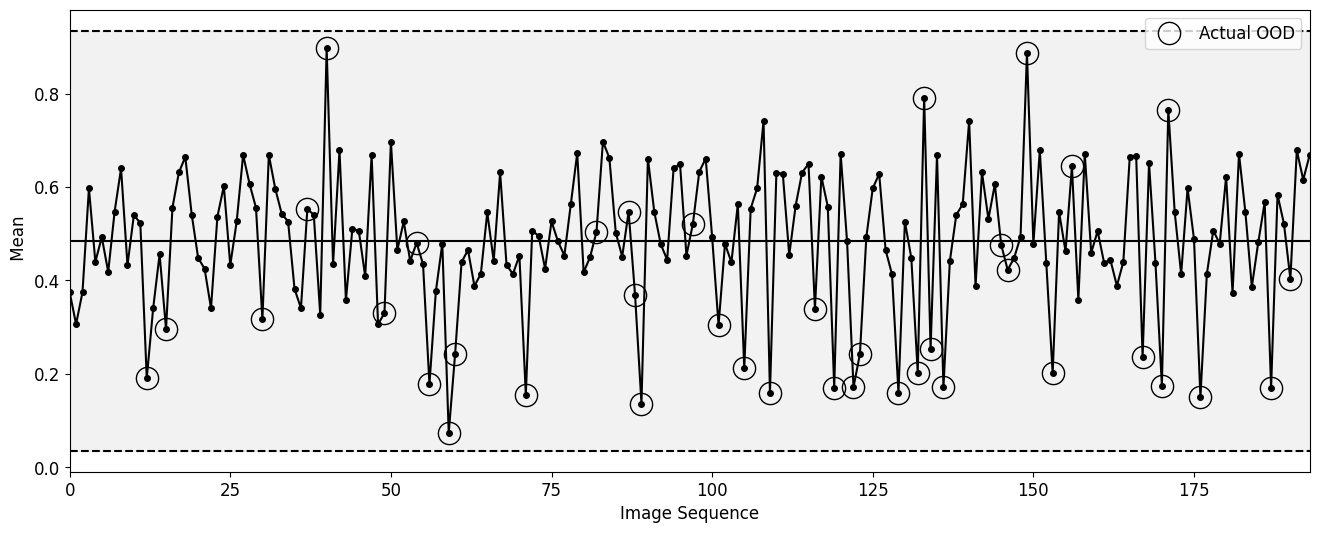

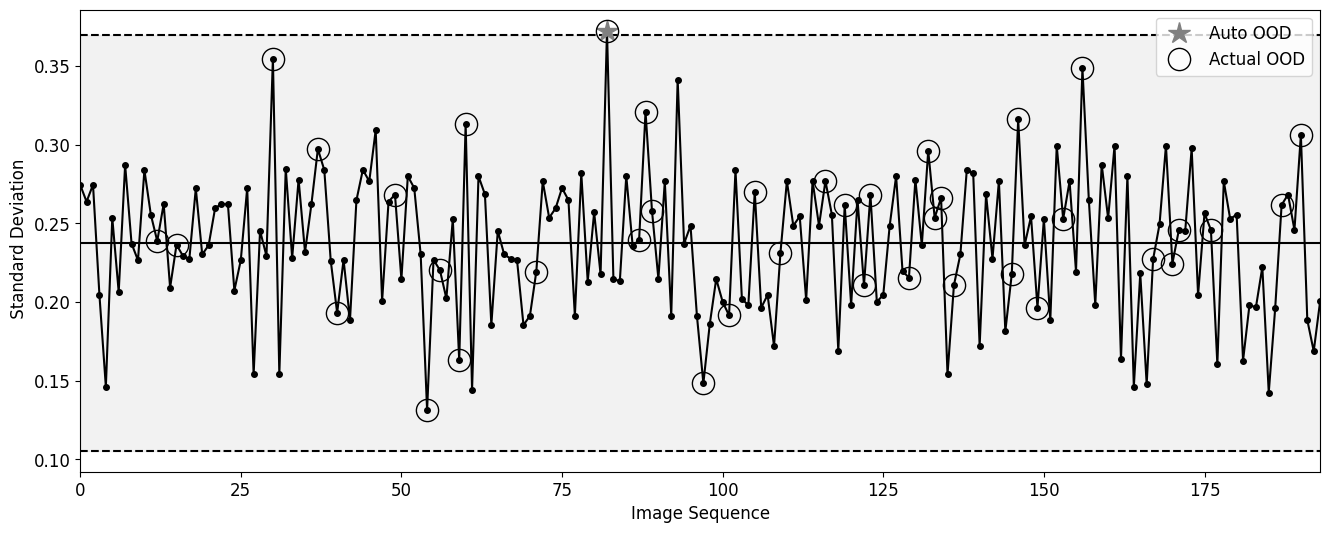

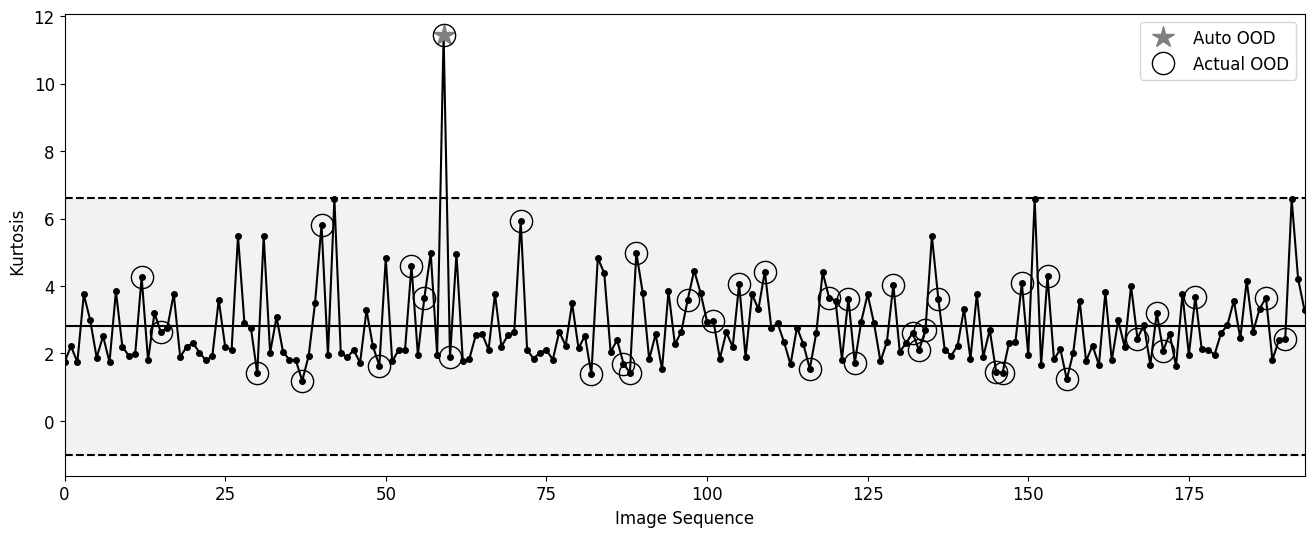

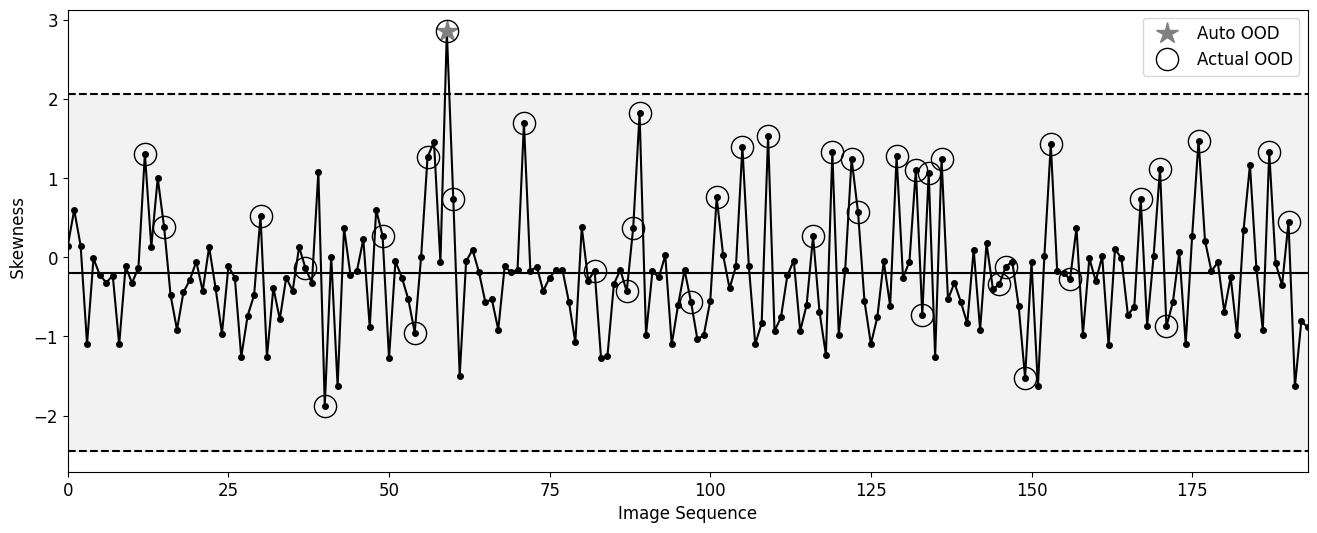

Image names, corresponding days, and statistics saved to /content/drive/MyDrive/image_days_statistics_v2.csv


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


ood_labels = ['out' in filename for filename in df.index]


# Load the statistics from the CSV file
df = pd.read_csv(csv_path, index_col=0)


# Create a new DataFrame for storing image names, corresponding days, and statistics
output_data = {
    'Image Name': [],
    'Day': [],
    'Statistic Value': []
}


def process_and_plot_spc(statistic_name, ood_labels):
    data = df[statistic_name].values
    days = range(1, len(data) + 1)
    mean_val = np.mean(data)
    std_val = np.std(data)
    UCL = mean_val + 3*std_val
    LCL = mean_val - 3*std_val

    for rule in ["Rule 1"]:
        plot_spc_chart(data, mean_val, UCL, LCL, f" {statistic_name}", rule, ood_labels)

    # Update the output_data DataFrame
    output_data['Image Name'].extend(df.index)
    output_data['Day'].extend(days)
    output_data['Statistic Value'].extend(data)

for statistic in ["Mean", "Standard Deviation", "Kurtosis", "Skewness"]:
    process_and_plot_spc(statistic, ood_labels)


# Save the image names, corresponding days, and statistics to a new CSV
output_df = pd.DataFrame(output_data)
csv_output_path = os.path.join('/content/drive/MyDrive/', 'image_days_statistics_v2.csv')
output_df.to_csv(csv_output_path, index=False)

print(f"Image names, corresponding days, and statistics saved to {csv_output_path}")


In [ ]:
def plot_spc_chart_gt(distances, mean, UCL, LCL, title, rule):
    """Plot SPC chart for a specific rule with a caption and save the figure."""
    plt.figure(figsize=(20, 6))  # Increased width for better spacing on the x-axis

    plt.plot(distances, color='grey', marker='o', markersize=4)
    plt.axhline(y=mean, color='red', linestyle='-', label='Mean')
    plt.axhline(y=UCL, color='green', linestyle='--', label='UCL')
    plt.axhline(y=LCL, color='green', linestyle='--', label='LCL')
    plt.fill_between(range(len(distances)), LCL, UCL, color='grey', alpha=0.1)

    # Identify OOD image indices
    ood_indices = [i for i, img_name in enumerate(df.index) if 'imagenet' in img_name]
    for idx in ood_indices:
        plt.scatter(idx, distances[idx], s=200, facecolors='none', edgecolors='b')

    # Highlight violations for the specified rule
    violations = apply_spc_rules(distances, mean, UCL - mean)
    for idx in violations[rule]:
        plt.plot(idx, distances[idx], 'o', color='purple')

    plt.title(f"{title} ({rule} Violations)")
    plt.xlim(0, len(distances)-1)  # Ensure x-axis starts from 0

    # Caption explaining the rule
    rule_definitions = {
        "Rule 1": "Any single data point more than 3σ from the center line.",
        "Rule 2": "Nine points in a row on one side of the center line.",
        "Rule 3": "Six (or more) points in a row, all increasing (or decreasing).",
        "Rule 4": "Fourteen (or more) points in a row, alternating up and down."
    }
    plt.figtext(0.5, -0.1, rule_definitions[rule], wrap=True, horizontalalignment='center', fontsize=10)

    # Save the figure
    save_path = os.path.join('/content/drive/MyDrive/', f"{title}_{rule}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Chart saved at: {save_path}")
